In [1]:
import mlrose
import pandas as pd
import numpy as np
import timeit

import pickle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

%mkdir figures
%load_ext autoreload
%autoreload 2

url = 'https://raw.githubusercontent.com/tuanyuan2008/cs4641/master/datasets/PhishingWebsitesData.csv'
# Dataset is now stored in a Pandas Dataframe

A subdirectory or file figures already exists.


In [2]:
## Download the Phishing Data from OpenML https://www.openml.org/d/4534

df_phish = pd.read_csv(url).astype('category')
print("Data has",len(df_phish),"rows and", len(df_phish.columns),"columns.")
if df_phish.isnull().values.any():
    print("Warning: Missing Data")
#df_phish.head()
#df_phish.describe(include='all')

Data has 11055 rows and 31 columns.


In [3]:
col_1hot = ['URL_Length','having_Sub_Domain','SSLfinal_State','URL_of_Anchor','Links_in_tags','SFH','web_traffic','Links_pointing_to_page']
df_1hot = df_phish[col_1hot]
df_1hot = pd.get_dummies(df_1hot)
df_others = df_phish.drop(col_1hot,axis=1)
df_phish = pd.concat([df_1hot,df_others],axis=1)
df_phish = df_phish.replace(-1,0).astype('category')
column_order = list(df_phish)
column_order.insert(0, column_order.pop(column_order.index('Result')))
df_phish = df_phish.loc[:, column_order]  #move the target variable 'Result' to the front
df_phish.describe(include='all')

,Result,URL_Length_-1,URL_Length_0,URL_Length_1,having_Sub_Domain_-1,having_Sub_Domain_0,having_Sub_Domain_1,SSLfinal_State_-1,SSLfinal_State_0,SSLfinal_State_1,...,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,Page_Rank,Google_Index,Statistical_report
count,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055,...,11055,11055,11055,11055,11055,11055,11055,11055,11055,11055
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,1,1,0,0,0,0,0,0,0,1,...,0,1,1,1,1,1,1,0,1,1
freq,6157,8960,10920,9095,7692,7433,6985,7498,9888,6331,...,9776,9740,10579,8918,10043,5866,7612,8201,9516,9505


In [4]:
def import_data():

    X1 = np.array(df_phish.values[:,1:-1],dtype='int64')
    Y1 = np.array(df_phish.values[:,0],dtype='int64')

    return X1, Y1

In [5]:
# Neural Net with Random Optimization
x, y = import_data()
kf = KFold(n_splits=5)
np.random.seed(1)
acc_tr = {}
time_tr = {}
acc_te = {}
time_te = {}

In [6]:
def evaluate(algo_name, param_name, clf, kf):
    if algo_name not in acc_tr:
        acc_tr[algo_name] = {}
        acc_te[algo_name] = {}
        time_tr[algo_name] = {}
        time_te[algo_name] = {}
    if param_name not in acc_tr[algo_name]:
        acc_tr[algo_name][param_name] = []
        acc_te[algo_name][param_name] = []
        time_tr[algo_name][param_name] = []
        time_te[algo_name][param_name] = []
    eval_tr = []
    eval_te = []
    eval_trtime = []
    eval_tetime = []
    for train_index, test_index in kf.split(x):
        x_tr, x_te = x[train_index], x[test_index]
        y_tr, y_te = y[train_index], y[test_index]
        
        time_start = timeit.default_timer()
        clf.fit(x_tr, y_tr)
        eval_trtime.append((timeit.default_timer() - time_start))
        
        time_start_pred = timeit.default_timer()
        y_train_pred = clf.predict(x_tr)
        y_te_pred = clf.predict(x_te)
        eval_tetime.append((timeit.default_timer() - time_start_pred))
        
        y_train_accuracy = accuracy_score(y_tr, y_train_pred)
        y_te_accuracy = accuracy_score(y_te, y_te_pred)
        eval_tr.append(y_train_accuracy)    
        eval_te.append(y_te_accuracy)
        
    eval_trtime = np.array(eval_trtime).mean() / 1000
    eval_tetime = np.array(eval_tetime).mean() / 1000
    eval_tr = np.array(eval_tr).mean()
    eval_te = np.array(eval_te).mean()
    
    acc_tr[algo_name][param_name].append(eval_tr)
    acc_te[algo_name][param_name].append(eval_te)    
    time_tr[algo_name][param_name].append(eval_trtime)
    time_te[algo_name][param_name].append(eval_tetime)

In [7]:
iteration_range = range(250, 2250, 250)

In [8]:
for it in iteration_range:
    algo = 'backprop'
    clf = mlrose.NeuralNetwork(hidden_nodes = [6], activation = 'relu', \
                                     algorithm = 'gradient_descent', max_iters = it, \
                                     bias = True, is_classifier = True, learning_rate = 0.0001, \
                                     early_stopping = True, clip_max = 5, max_attempts = 100)
    evaluate(algo, 'iter', clf, kf)
    algo= 'rhc'
    clf = mlrose.NeuralNetwork(hidden_nodes = [6], activation = 'relu', \
                                     algorithm = 'random_hill_climb', max_iters = it, \
                                     bias = True, is_classifier = True, learning_rate = 0.1, \
                                     early_stopping = True, clip_max = 5, restarts=5, max_attempts = 100)
    evaluate(algo, 'iter', clf, kf)
    algo = 'sa'
    clf = mlrose.NeuralNetwork(hidden_nodes = [6], activation = 'relu', \
                                     algorithm = 'simulated_annealing', max_iters = it, \
                                     bias = True, is_classifier = True, learning_rate = 0.1, \
                                     early_stopping = True, clip_max = 5, max_attempts = 100)
    evaluate(algo, 'iter', clf, kf)
    algo='ga'
    clf = mlrose.NeuralNetwork(hidden_nodes = [6], activation = 'relu', \
                                     algorithm = 'genetic_alg', max_iters = it, \
                                     bias = True, is_classifier = True, learning_rate = 0.1, \
                                     early_stopping = True, clip_max = 5, max_attempts = 100)
    evaluate(algo, 'iter', clf, kf)

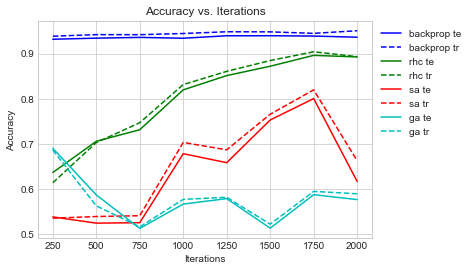

In [9]:
plt.plot(iteration_range, acc_te['backprop']['iter'], label='backprop te', linestyle='-', color='b')
plt.plot(iteration_range, acc_tr['backprop']['iter'], label='backprop tr', linestyle='--', color='b')

plt.plot(iteration_range, acc_te['rhc']['iter'], label='rhc te', linestyle='-', color='g')
plt.plot(iteration_range, acc_tr['rhc']['iter'], label='rhc tr', linestyle='--', color='g')

plt.plot(iteration_range, acc_te['sa']['iter'], label='sa te', linestyle='-', color='r')
plt.plot(iteration_range, acc_tr['sa']['iter'], label='sa tr', linestyle='--', color='r')

plt.plot(iteration_range, acc_te['ga']['iter'], label='ga te', linestyle='-', color='c')
plt.plot(iteration_range, acc_tr['ga']['iter'], label='ga tr', linestyle='--', color='c')
plt.ylabel("Accuracy")
plt.xlabel("Iterations")
plt.title("Accuracy vs. Iterations")
plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.savefig('figures/_net_acc_iter.png')

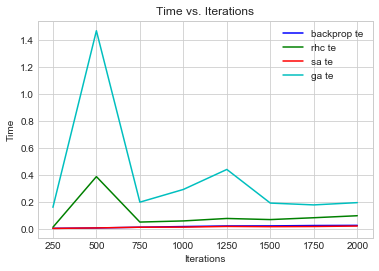

In [10]:
plt.plot(iteration_range, time_tr['backprop']['iter'], label='backprop te', linestyle='-', color='b')

plt.plot(iteration_range, time_tr['rhc']['iter'], label='rhc te', linestyle='-', color='g')

plt.plot(iteration_range, time_tr['sa']['iter'], label='sa te', linestyle='-', color='r')

plt.plot(iteration_range, time_tr['ga']['iter'], label='ga te', linestyle='-', color='c')
plt.ylabel("Time")
plt.xlabel("Iterations")
plt.title("Time vs. Iterations")
plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.savefig('figures/_net_time_iter.png')

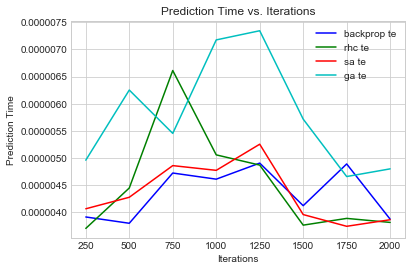

In [11]:
plt.plot(iteration_range, time_te['backprop']['iter'], label='backprop te', linestyle='-', color='b')

plt.plot(iteration_range, time_te['rhc']['iter'], label='rhc te', linestyle='-', color='g')

plt.plot(iteration_range, time_te['sa']['iter'], label='sa te', linestyle='-', color='r')

plt.plot(iteration_range, time_te['ga']['iter'], label='ga te', linestyle='-', color='c')
plt.ylabel("Prediction Time")
plt.xlabel("Iterations")
plt.title("Prediction Time vs. Iterations")
plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.savefig('figures/_net_pred_time_iter.png')